In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader, Subset
from tensorflow.keras.utils import pad_sequences

from torch.utils.data import TensorDataset, DataLoader, Subset
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


tqdm.pandas()

# 데이터 Load

In [2]:
from datasets import load_dataset

dataset = load_dataset("bentrevett/multi30k")

# Spacy 사용

In [3]:
import spacy
nlp_en= spacy.load("en_core_web_sm")
nlp_ge = spacy.load("de_core_news_sm")


In [4]:
stopwords_en = spacy.lang.en.stop_words.STOP_WORDS
stopwords_ge = spacy.lang.en.stop_words.STOP_WORDS 



In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

## 사전 (Vocabulary 집) 생성

In [6]:
# train_en = np.array('')
# train_ge = np.array('')

# for i,j in zip(tqdm(dataset['train']['en']),dataset['train']['de']):
#     train_en = np.append(train_en, np.array([k.text for k in nlp_en(i) if k.text not in list(stopwords_en)]))
#     train_ge = np.append(train_ge, np.array([k.text for k in nlp_ge(j) if k.text not in list(stopwords_ge)]))

        
# valid_en = np.array('')
# valid_ge = np.array('')
    
        
# for i,j in zip(tqdm(dataset['validation']['en']),dataset['validation']['de']):
#     valid_en = np.append(valid_en, np.array([k.text for k in nlp_en(i) if k.text not in list(stopwords_en)]))
#     valid_ge = np.append(valid_ge, np.array([k.text for k in nlp_ge(j) if k.text not in list(stopwords_ge)]))

        
# test_en = np.array('')
# test_ge = np.array('')

# for i,j in zip(tqdm(dataset['test']['en']),dataset['test']['de']):
#     test_en = np.append(test_en, np.array([k.text for k in nlp_en(i) if k.text not in list(stopwords_en)]))
#     test_ge = np.append(test_ge, np.array([k.text for k in nlp_ge(j) if k.text not in list(stopwords_ge)]))


    

In [7]:
# import pickle
# import gzip

# # save and compress.
# with gzip.open('train_en.pickle', 'wb') as f:
#     pickle.dump(train_en, f)
# with gzip.open('train_ge.pickle', 'wb') as f:
#     pickle.dump(train_ge, f)


# # save and compress.
# with gzip.open('test_en.pickle', 'wb') as f:
#     pickle.dump(test_en, f)
# with gzip.open('test_ge.pickle', 'wb') as f:
#     pickle.dump(test_ge, f)


# # save and compress.
# with gzip.open('valid_en.pickle', 'wb') as f:
#     pickle.dump(valid_en, f)
# with gzip.open('valid_ge.pickle', 'wb') as f:
#     pickle.dump(valid_ge, f)




In [8]:
import pickle
import gzip

# load and uncompress.
with gzip.open('train_en.pickle','rb') as f:
    train_en = pickle.load(f)[1:]
with gzip.open('train_ge.pickle','rb') as f:
    train_ge = pickle.load(f)[1:]
    

# load and uncompress.
with gzip.open('test_en.pickle','rb') as f:
    test_en = pickle.load(f)[1:]
with gzip.open('test_ge.pickle','rb') as f:
    test_ge = pickle.load(f)[1:]
    
    
# load and uncompress.
with gzip.open('valid_en.pickle','rb') as f:
    valid_en = pickle.load(f)[1:]
with gzip.open('valid_ge.pickle','rb') as f:
    valid_ge = pickle.load(f)[1:]

In [9]:
train_all = np.append(train_en ,train_ge)

In [10]:
len(set(train_all))

28776

In [11]:
ww_dict = {}
ww_num_dict = {}
num = 4  # 0 : pad / 1 : start / 2 : end / 3 : unk

# 정수 인코딩
for www in tqdm(train_all):
    if www.strip() in ww_dict.keys():
        ww_num_dict[www.strip()] += 1
        pass
    else:
        ww_dict[www.strip()] = num
        ww_num_dict[www.strip()] = 1
        num += 1

  0%|          | 0/587122 [00:00<?, ?it/s]

100%|██████████| 587122/587122 [00:00<00:00, 703824.97it/s]


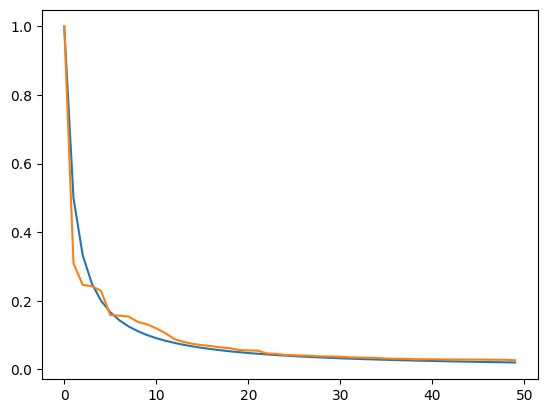

In [12]:
plot = sorted(ww_num_dict.values(), reverse = True)

# Vocabulary dictionary를 만들 시 Zipf's law를 따라여 어느 정도 중요한 어구를 잘 나타내고 있다고 볼 수 있다.
# (그렇지 않으면 해당 token들은 전체 문서의 특성을 잘 못 나타낸다고 볼 수 있다.)
# 그림을 그려보니 해당 tokenize는 전체 문서의 특성을 잘 나타내지 못한다고 볼 수 있다.` 말고 다른 것을 사용해보자. : 그냥 Hard하게 하자.
import matplotlib.pyplot as plt

N = 50
M =0
max_freq = plot[M]

plt.plot(range(0, N), [1/i for i in range(1, N+1)])
plt.plot(range(0, N) ,[i/max_freq for i in plot[M:M+N]])

In [13]:
len(ww_dict.keys())

28774

In [14]:
len(sorted(ww_dict.items(),key=lambda x:x[1], reverse=True))

28774

## 정수 인코딩

In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

In [16]:
# train_data_en = []
# train_data_ge = []

# for i,j in zip(tqdm(dataset['train']['en']),dataset['train']['de']):
#     train_data_en.append([ww_dict[k.text.strip()] for k in nlp_en(i) if k.text not in list(stopwords_en)])
#     train_data_ge.append([ww_dict[k.text.strip()] for k in nlp_ge(j) if k.text not in list(stopwords_ge)])

In [17]:
# test_data_en = []
# test_data_ge = []

# # train 데이터 기준으로 vocab을 만듦으로 test / valid 데이터에 대해서는 unk을 넣어야 한다.
# # 0 : pad / 1 : start / 2 : end / 3 : unk

# for i,j in zip(tqdm(dataset['test']['en']),dataset['test']['de']):
#     small_lst = []
#     for k in nlp_en(i):
#         if (k.text in list(stopwords_en)):
#             pass
#         else:
#             if (k.text.strip() in ww_dict.keys()):
#                 small_lst.append(ww_dict[k.text.strip()])
#             else:
#                 small_lst.append(3)    
#     test_data_en.append(small_lst)
    
#     small_lst = []
#     for k in nlp_ge(j):
#         if (k.text in list(stopwords_ge)):
#             pass
#         else:
#             if (k.text.strip() in ww_dict.keys()):
#                 small_lst.append(ww_dict[k.text.strip()])
#             else:
#                 small_lst.append(3)    
#     test_data_ge.append(small_lst)

In [18]:
        
# valid_data_en = []
# valid_data_ge = []

# for i,j in zip(tqdm(dataset['validation']['en']),dataset['validation']['de']):
    
#     small_lst = []
#     for k in nlp_en(i):
#         if (k.text in list(stopwords_en)):
#             pass
#         else:
#             if (k.text.strip() in ww_dict.keys()):
#                 small_lst.append(ww_dict[k.text.strip()])
#             else:
#                 small_lst.append(3)    
#     valid_data_en.append(small_lst)
    
#     small_lst = []    
#     for k in nlp_ge(j):

#         if (k.text in list(stopwords_ge)):
#             pass
#         else:
#             if (k.text.strip() in ww_dict.keys()):
#                 small_lst.append(ww_dict[k.text.strip()])
#             else:
#                 small_lst.append(3)    
#     valid_data_ge.append(small_lst)
            

In [19]:
# import pickle
# import gzip

# # save and compress.
# with gzip.open('train_data_en.pickle', 'wb') as f:
#     pickle.dump(train_data_en, f)
# with gzip.open('train_data_ge.pickle', 'wb') as f:
#     pickle.dump(train_data_ge, f)


# # save and compress.
# with gzip.open('test_data_en.pickle', 'wb') as f:
#     pickle.dump(test_data_en, f)
# with gzip.open('test_data_ge.pickle', 'wb') as f:
#     pickle.dump(test_data_ge, f)


# # save and compress.
# with gzip.open('valid_data_en.pickle', 'wb') as f:
#     pickle.dump(valid_data_en, f)
# with gzip.open('valid_data_ge.pickle', 'wb') as f:
#     pickle.dump(valid_data_ge, f)


In [20]:
import pickle
import gzip

# load and uncompress.
with gzip.open('train_data_en.pickle','rb') as f:
    train_data_en = pickle.load(f)[1:]
with gzip.open('train_data_ge.pickle','rb') as f:
    train_data_ge = pickle.load(f)[1:]
    

# load and uncompress.
with gzip.open('test_data_en.pickle','rb') as f:
    test_data_en = pickle.load(f)[1:]
with gzip.open('test_data_ge.pickle','rb') as f:
    test_data_ge = pickle.load(f)[1:]
    
    
# load and uncompress.
with gzip.open('valid_data_en.pickle','rb') as f:
    valid_data_en = pickle.load(f)[1:]
with gzip.open('valid_data_ge.pickle','rb') as f:
    valid_data_ge = pickle.load(f)[1:]

In [21]:
def pad_sequences_en(sequences):
    max_len = 128
    padded_sequences = []
    for sequence in sequences:
        if len(sequence) >= max_len:
            padded_sequence = sequence[:max_len-1] + [2]  # 최대 길이까지 잘라냄
        else:
            padded_sequence = sequence + [2] + [0] * (max_len - len(sequence) - 1)  # 패딩 추가
        padded_sequences.append(padded_sequence)
    return padded_sequences

In [22]:
def pad_sequences_de(sequences):
    max_len = 128
    padded_sequences = []
    for sequence in sequences:
        if len(sequence) >= max_len:
            padded_sequence = [1] + [2] + sequence[:max_len-2]  # 최대 길이까지 잘라냄
        else:
            padded_sequence = [1] + sequence + [2] + [0] * (max_len - len(sequence) - 2)  # 패딩 추가
        padded_sequences.append(padded_sequence)
    return padded_sequences

In [23]:
train_en_final, train_ge_final = torch.tensor(pad_sequences_en(train_data_en)), torch.tensor(pad_sequences_de(train_data_ge))
valid_en_final, valid_ge_final = torch.tensor(pad_sequences_en(valid_data_en)), torch.tensor(pad_sequences_de(valid_data_ge))
test_en_final, test_ge_final = torch.tensor(pad_sequences_en(test_data_en)), torch.tensor(pad_sequences_de(test_data_ge))

In [24]:
set([len(i) for i in train_en]), set([len(i) for i in train_ge])

({1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16},
 {1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  33,
  36})

In [25]:
class Dataset(Dataset):
    
    def __init__(self, inputs, output):

        self.inputs = inputs
        self.output = output

    def __getitem__(self, idx):

        inputs = self.inputs[idx]
        output = self.output[idx]
        
        return inputs, output

    def __len__(self):
        return len(self.output)

In [26]:
train_dataset = Dataset(train_en_final, train_ge_final)
valid_dataset = Dataset(valid_en_final, valid_ge_final)
test_dataset = Dataset(test_en_final, test_ge_final)

In [27]:



train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = False, drop_last = True)
valid_loader = DataLoader(valid_dataset, batch_size = 64, shuffle = False, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False, drop_last = True)

In [28]:
len(valid_loader)

15

# Model

In [29]:
import math

class Embeddings(nn.Module):


    def __init__(self, vocab_size, d_model, max_len = 128):
        super(Embeddings, self).__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(0.1)
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pe = self.create_positinal_encoding(max_len, self.d_model)
        self.dropout = nn.Dropout(0.1)

    def create_positinal_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model).to(device)
        for pos in range(max_len):  
            for i in range(0, d_model, 2):  
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        pe = pe.unsqueeze(0)  
        return pe

    def forward(self, encoded_words):
        
        embedding = self.embed(encoded_words) * torch.sqrt(torch.tensor(self.d_model)).to(device)
        embedding += self.pe[:, :embedding.size(1)]   
        embedding = self.dropout(embedding)
        return embedding

In [30]:
# class Attention(nn.Module):
    
#     def __init__(self, embedding_size = 512):
        
#         self.data = data
#         self.embedding_size= embedding_size
#         self.weight_Q = nn.Linear(embedding_size, embedding_size)
#         self.weight_K = nn.Linear(embedding_size, embedding_size)
#         self.weight_V = nn.Linear(embedding_size, embedding_size)
#         self.softmax = nn.Softmax()
        
#     def forward(self, data):
        
#         Q = self.weight_Q(data)
#         K = self.weight_K(data)
#         V = self.weight_V(data)
#         score = torch.matmul(Q,K.T) / torch.sqrt(self.embedding_size)
#         value = self.softmax(score) * V
#         return value
         

In [31]:
def create_masks(inputs, outputs_input, outputs_target):
    
    def subsequent_mask(size):
        mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype = torch.uint8)
        return mask.unsqueeze(0) # 상삼각행렬 생성 -> 행과 열을 뒤 바꾸어 하삼각행렬로 바꿈. (밑에가 다 0)
    
    inputs_mask = inputs != 0
    inputs_mask = inputs_mask.to(device)
    inputs_mask = inputs_mask.unsqueeze(1).unsqueeze(1) # 각  input에 대해서 상삼각행렬에 대응하도록 설정.
    
    outputs_input_mask = outputs_input != 0
    outputs_input_mask = outputs_input_mask.unsqueeze(1) 
    outputs_input_mask = outputs_input_mask & subsequent_mask(outputs_input.size(-1)).type_as(outputs_input_mask.data)
    outputs_input_mask = outputs_input_mask.unsqueeze(1)
    # masking을 해줌으로서, 

    
    outputs_target_mask = outputs_target != 0
    
    return inputs_mask, outputs_input_mask, outputs_target_mask
        
        

In [32]:
len(train_en_final[0])

128

In [33]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, heads, d_model):
        super(MultiHeadAttention, self).__init__()
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = nn.Dropout(0.1)
        self.query = nn.Linear(d_model, d_model)
        self.key  = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.concat = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask):
        
        query = self.query(query)
        key = self.key(key)
        value = self.value(value)
        
        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        

        scores = torch.matmul(query, key.permute(0 ,1 ,3, 2)) / math.sqrt(query.size(-1))
        
        # print(query.shape, key.shape, value.shape, mask.shape, scores.shape)

        
        scores = scores.masked_fill(mask == 0, -1e9) # masking 된 것에 매우 작은 수 부여 -> softmax 계산시 -inf 로 계산되어짐.
        weights = F.softmax(scores, dim = -1) # attention score 계산
        context = torch.matmul(weights, value)  # attention value 계산
        context = context.permute(0,2,1,3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)
        
        interacted = self.concat(context)
        
        return interacted
        
        

In [34]:
class FeedForward(nn.Module):
    
    def __init__(self, d_model, middle_dim = 2048):
        super(FeedForward, self).__init__()
        
        self.fc1 = nn.Linear(d_model, middle_dim)
        self.fc2 = nn.Linear(middle_dim, d_model)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self,x):
        out = F.relu(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out        

In [35]:
class EncoderLayer(nn.Module):
    
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, embeddings, mask):
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        interacted = self.layernorm(interacted + embeddings)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded
        

In [36]:
class DecoderLayer(nn.Module):
    
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.src_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, embeddings, encoded, src_mask, target_mask):
        query = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, target_mask))
        query = self.layernorm(query + embeddings)
        interacted = self.dropout(self.src_multihead(query, encoded, encoded, src_mask))
        interacted = self.layernorm(interacted + query)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        decoded = self.layernorm(feed_forward_out + interacted)
        return decoded

In [37]:
class P_Transformer(nn.Module):
    
    def __init__(self, d_model, heads, num_layers, vocab_size):
        super(P_Transformer, self).__init__()
        
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embed = Embeddings(self.vocab_size, d_model)
        self.encoder = nn.ModuleList([EncoderLayer(d_model, heads) for _ in range(num_layers)])
        self.decoder = nn.ModuleList([DecoderLayer(d_model, heads) for _ in range(num_layers)])
        self.logit = nn.Linear(d_model, self.vocab_size)
        
    def encode(self, src_words, src_mask):
        src_embeddings = self.embed(src_words)
        encoded_layers = []
        for layer in self.encoder:
            src_embeddings = layer(src_embeddings, src_mask)
            encoded_layers.append(src_embeddings)
            
        return encoded_layers

    def decode(self, target_words, target_mask, src_embeddings, src_mask):
        tgt_embeddings = self.embed(target_words)
        for i, layer in enumerate(self.decoder):
            tgt_embeddings = layer(tgt_embeddings, src_embeddings[i], src_mask, target_mask)
        return tgt_embeddings

    def forward(self, src_words, src_mask, target_words, target_mask):
        encoded_layers = self.encode(src_words, src_mask)
        decoded = self.decode(target_words, target_mask, encoded_layers, src_mask)
        out = F.log_softmax(self.logit(decoded), dim = 2)
        return out

In [38]:
class Transformer(nn.Module):
    
    def __init__(self, d_model, heads, num_layers, vocab_size):
        super(Transformer, self).__init__()
        
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embed = Embeddings(self.vocab_size, d_model)
        self.encoder = nn.ModuleList([EncoderLayer(d_model, heads) for _ in range(num_layers)])
        self.decoder = nn.ModuleList([DecoderLayer(d_model, heads) for _ in range(num_layers)])
        self.logit = nn.Linear(d_model, self.vocab_size)
        
    def encode(self, src_words, src_mask):
        src_embeddings = self.embed(src_words)
        
        for layer in self.encoder:
            src_embeddings = layer(src_embeddings, src_mask)
            
        return src_embeddings

    def decode(self, target_words, target_mask, src_embeddings, src_mask):
        tgt_embeddings = self.embed(target_words)
        for layer in self.decoder:
            tgt_embeddings = layer(tgt_embeddings, src_embeddings, src_mask, target_mask)
        return tgt_embeddings

    def forward(self, src_words, src_mask, target_words, target_mask):
        encoded = self.encode(src_words, src_mask)
        decoded = self.decode(target_words, target_mask, encoded, src_mask)
        out = F.log_softmax(self.logit(decoded), dim = 2)
        return out
            

In [39]:
class AdamWarmup:
    
    def __init__(self, model_size, warmup_steps, optimizer):
        
        self.model_size = model_size
        self.warmup_steps = warmup_steps
        self.optimizer = optimizer
        self.current_step = 0
        self.lr = 0
    
    def get_lr(self):
        return self.model_size ** (-0.5) * min(self.current_step ** (-0.5), self.current_step * self.warmup_steps ** (-1.5))
    
    def step(self):
        
        self.current_step += 1
        lr = self.get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
            
        self.lr = lr
        self.optimizer.step()

In [40]:
import torch.nn.functional as F

class LossWithLS(nn.Module):
    
    def __init__(self, size, smooth):
        super(LossWithLS, self).__init__()
        self.smooth = smooth
        self.size = size

    def forward(self, prediction, target, mask):
        prediction = prediction.view(-1, prediction.size(-1))   # (batch_size * max_words, vocab_size)
        target = target.contiguous().view(-1)   # (batch_size * max_words)
        mask = mask.float()
        mask = mask.view(-1)       # (batch_size * max_words)
        
        # Smoothed one-hot labels
        labels = torch.full_like(prediction, self.smooth / (self.size - 1))
        labels.scatter_(1, target.unsqueeze(1), 1 - self.smooth)
        
        # Apply mask
        masked_prediction = prediction * mask.unsqueeze(1)
        masked_labels = labels * mask.unsqueeze(1)

        
        # Calculate negative log likelihood loss
        loss = F.nll_loss(masked_prediction, target, reduction='none')
        loss *= mask
        
        # Normalize the loss
        loss = loss.sum() / mask.sum()
        
        return loss

# Training

In [41]:
128 / 8

16.0

In [42]:
d_model = 64
heads = 8
num_layers = 6
num_layers = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10
vocab_len = len(ww_dict.keys()) + 4

transformer = P_Transformer(d_model = d_model , heads = heads, num_layers = num_layers, vocab_size = vocab_len)
transformer = transformer.to(device)
adam_optimizer = torch.optim.Adam(transformer.parameters())
transformer_optimizer = AdamWarmup(model_size = d_model, warmup_steps = 4000, optimizer = adam_optimizer)
criterion = LossWithLS(vocab_len, 0.1)

In [43]:
next(iter(train_loader.dataset))[1].shape

torch.Size([128])

In [44]:
import wandb


wandb.init(
    # set the wandb project where this run will be logged
    project="P_Transformer_Hard_Coding",

    # track hyperparameters and run metadata
    config={
    "loss": 'Cross_Entropy_loss',
    "architecture": "P_Transformer",
    "optimizer" : 'AdamWarmup',
    'layer' : 6,
    'heads' : 8,
    'd_model' : 64   
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yoon303b (ku_software). Use `wandb login --relogin` to force relogin


In [45]:


import torch
import torch.nn.functional as F
import random

def generate_next_words(transformer, sequence, encoded, question_mask, beam_width):
    
    # pad : 0 / start : 1 / end : 2 / unk : 3
    start_token = 1
    
    if not sequence:
        return [(start_token, 0)]
    
    size = len(sequence)
    target_mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
    target_mask = target_mask.to(device).unsqueeze(0).unsqueeze(0)

    words = torch.LongTensor([sequence]).to(device)

    decoded = transformer.decode(words, target_mask, encoded, question_mask)
    predictions = transformer.logit(decoded[:, -1])

    # Apply log_softmax
    log_probs = F.log_softmax(predictions, dim = -1)

    # Get top-k words
    top_k_probs, top_k_indices = torch.topk(log_probs, beam_width, dim=-1)
    top_k_probs = top_k_probs.squeeze().tolist()
    top_k_indices = top_k_indices.squeeze().tolist()

    next_words = [(word, prob) for word, prob in zip(top_k_indices, top_k_probs)]
    return next_words


def beam_search(transformer, question, question_mask, max_len, dict, beam_width=5):
    transformer.eval()
    start_token = 1
    end_token = 2

    encoded = transformer.encode(question, question_mask)

    beams = [([], 0)] 

    for step in range(max_len):
        candidates = []

        for seq, score in beams:
            if seq and seq[-1] == end_token:
                candidates.append((seq, score))
                continue
            
            next_words = generate_next_words(transformer, seq, encoded, question_mask, beam_width)

            for word, log_prob in next_words:
                candidates.append((seq + [word], score + log_prob))

        # Select top-k candidates
        candidates.sort(key=lambda x: x[1], reverse=True)
        beams = candidates[:beam_width]

        # Check if all beams have ended
        if all(seq[-1] == end_token for seq, _ in beams):
            break

    best_seq, _ = max(beams, key=lambda x: x[1])
    return best_seq

In [46]:


bb = {v:k for k,v in ww_dict.items()} 

bb[0] = '<pad>'
bb[1] = '<start>'
bb[2] = '<end>'
bb[3] = '<unk>'

In [47]:
def train(train_loader, transformer, criterion, epoch):
    
    transformer.train()
    sum_loss, valid_sum_loss = 0, 0
    count, valid_count = 0, 0
    
    for i, (inputs, output) in enumerate(train_loader):
        
        samples = inputs.shape[0]
        
        inputs = inputs.to(device)
        output = output.to(device)
        
        output_in = output[:,:-1]
        output_target = output[:,1:]
        inputs_mask, output_in_mask, output_target_mask = create_masks(inputs, output_in, output_target)
        
        out = transformer(inputs, inputs_mask, output_in, output_in_mask)
        
        loss = criterion(out, output_target, output_target_mask)
        transformer_optimizer.optimizer.zero_grad()
        loss.backward()
        transformer_optimizer.step()
        
        sum_loss += loss.item() * samples
        count += samples
        
        if i % 5 == 0:
            print("Epoch [{}][{}/{}]\tTrain Loss: {:.3f}".format(epoch, i, len(train_loader), sum_loss/count))
            wandb.log({"Training loss" : sum_loss/count})
    
    transformer.eval()
    with torch.no_grad():
        for i, (inputs, output) in enumerate(valid_loader):
            
            samples = inputs.shape[0]
            
            inputs = inputs.to(device)
            output = output.to(device)
            
            output_in = output[:,:-1]
            output_target = output[:,1:]
            
            inputs_mask, output_in_mask, output_target_mask = create_masks(inputs, output_in, output_target)
            out = transformer(inputs, inputs_mask, output_in, output_in_mask)
            
            loss = criterion(out, output_target, output_target_mask)
            
            valid_sum_loss += loss.item() * samples
            valid_count += samples
        
            if i % 5   == 0:
                print("Epoch [{}][{}/{}]\t\t\tValid Loss: {:.3f}".format(epoch, i, len(valid_loader), valid_sum_loss/valid_count))
                wandb.log({"Validation loss" :  valid_sum_loss/valid_count })
                

    max_len = 128
    A = random.randint(1, 64)
    B = next(iter(test_loader))
    
    enc_qus = B[0][A]
    real_qus = B[1][A]
    question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
    question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)
    sentence = beam_search(transformer, question, question_mask, int(max_len), dict)
    
    candidate = [bb[i] for i in sentence if (i != 2) and (i != 0) and (i != 1)]
    real = [bb[i.tolist()] for i in real_qus if (i.tolist() != 2) and (i.tolist() != 0)  and (i != 1)]
    print()
    print('Candidate_labeled : ', [bb[i] for i in sentence])
    print('Candidate :'  + ' '.join(candidate))
    print('Real :' + ' '.join(real))


In [48]:
torch.Tensor((64, 128, 128)) * math.sqrt(128)

tensor([ 724.0773, 1448.1547, 1448.1547])

In [49]:
train_dataset = Dataset(train_en_final, train_ge_final)
valid_dataset = Dataset(valid_en_final, valid_ge_final)
test_dataset = Dataset(test_en_final, test_ge_final)


train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True, drop_last = True)
valid_loader = DataLoader(valid_dataset, batch_size = 64, shuffle = True, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False, drop_last = True)

In [50]:
len(train_en_final)

28998

In [51]:

random.randint(1, 15)

1

In [53]:
from datetime import datetime

epochs = 10

for epoch in range(epochs):
    
    start_time = datetime.now() 
    train(train_loader, transformer, criterion, epoch)
    
    state = {'epoch': epoch, 'transformer': transformer, 'transformer_optimizer': transformer_optimizer}
    torch.save(state, 'checkpoint_p_transformer_' + str(epoch + 10) + '.pth.tar')
    
    time_elapsed = datetime.now() - start_time 
    print('#######   Time elapsed (hh:mm:ss.ms) {} #######'.format(time_elapsed))
    print()

Epoch [0][0/453]	Train Loss: 2.042
Epoch [0][5/453]	Train Loss: 1.991
Epoch [0][10/453]	Train Loss: 1.962
Epoch [0][15/453]	Train Loss: 1.939
Epoch [0][20/453]	Train Loss: 1.931
Epoch [0][25/453]	Train Loss: 1.950
Epoch [0][30/453]	Train Loss: 1.944
Epoch [0][35/453]	Train Loss: 1.929
Epoch [0][40/453]	Train Loss: 1.925
Epoch [0][45/453]	Train Loss: 1.931
Epoch [0][50/453]	Train Loss: 1.924
Epoch [0][55/453]	Train Loss: 1.930
Epoch [0][60/453]	Train Loss: 1.933
Epoch [0][65/453]	Train Loss: 1.935
Epoch [0][70/453]	Train Loss: 1.939
Epoch [0][75/453]	Train Loss: 1.936
Epoch [0][80/453]	Train Loss: 1.937
Epoch [0][85/453]	Train Loss: 1.941
Epoch [0][90/453]	Train Loss: 1.943
Epoch [0][95/453]	Train Loss: 1.948
Epoch [0][100/453]	Train Loss: 1.949
Epoch [0][105/453]	Train Loss: 1.950
Epoch [0][110/453]	Train Loss: 1.954
Epoch [0][115/453]	Train Loss: 1.961
Epoch [0][120/453]	Train Loss: 1.963
Epoch [0][125/453]	Train Loss: 1.966
Epoch [0][130/453]	Train Loss: 1.965
Epoch [0][135/453]	Trai

KeyboardInterrupt: 

In [59]:
import torch
from copy import deepcopy

# 저장된 파일을 불러올 때
checkpoint = torch.load('checkpoint_p_transformer_11.pth.tar')

# 불러온 checkpoint에서 모델 상태나 다른 필요한 요소들을 추출할 수 있습니다.
transformer = deepcopy(checkpoint['transformer'])

# 모델을 evaluation 모드로 설정 (필요에 따라)
transformer.to(device)

P_Transformer(
  (embed): Embeddings(
    (dropout): Dropout(p=0.1, inplace=False)
    (embed): Embedding(28778, 64)
  )
  (encoder): ModuleList(
    (0-5): 6 x EncoderLayer(
      (layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (self_multihead): MultiHeadAttention(
        (dropout): Dropout(p=0.1, inplace=False)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (key): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (concat): Linear(in_features=64, out_features=64, bias=True)
      )
      (feed_forward): FeedForward(
        (fc1): Linear(in_features=64, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (decoder): ModuleList(
    (0-5): 6 x DecoderLayer(
      (layernorm): LayerNorm((64,), eps=1e

# BLEU Score

In [61]:
from tqdm import tqdm
import nltk.translate.bleu_score as bleu

candidate = []
real = []

max_len = 128

# pad : 0 / start : 1 / end : 2 / unk : 3

for a,b in zip(tqdm(test_en_final),test_ge_final):
    enc_qus = a
    real_qus = b
    question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
    
    question.to(device)
    real_qus.to(device)
    transformer.to(device)
    
    question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)
    sentence = beam_search(transformer, question, question_mask, int(max_len), dict)
    
    c = [bb[i] for i in sentence if (i != 0) and (i != 1) and (i != 2)]
    r = [bb[i.tolist()] for i in real_qus if (i.tolist() != 0) and (i.tolist() != 1)  and (i != 2)]
    
    candidate.append(c)
    real.append(r)
    
    data = 0
    
    for i,j in zip(real,candidate):
        data += bleu.sentence_bleu([i],j,weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method1)
        
        
    if len(real) % 10  == 0:
        print('BLEU -4 score : ', data / len(real))        


  1%|          | 10/999 [00:12<19:32,  1.19s/it]

BLEU -4 score :  0.3337512154858845


  2%|▏         | 20/999 [00:21<14:41,  1.11it/s]

BLEU -4 score :  0.18920783558232607


  3%|▎         | 30/999 [00:30<15:03,  1.07it/s]

BLEU -4 score :  0.17007941171469537


  4%|▍         | 40/999 [00:39<13:39,  1.17it/s]

BLEU -4 score :  0.19086096780031797


  5%|▌         | 50/999 [00:48<13:16,  1.19it/s]

BLEU -4 score :  0.21042885098148165


  6%|▌         | 60/999 [00:56<14:58,  1.04it/s]

BLEU -4 score :  0.19104696783077924


  7%|▋         | 70/999 [01:06<12:33,  1.23it/s]

BLEU -4 score :  0.18824528865915127


  8%|▊         | 80/999 [01:15<15:28,  1.01s/it]

BLEU -4 score :  0.18281986397697997


  9%|▉         | 90/999 [01:25<14:37,  1.04it/s]

BLEU -4 score :  0.17702178314578157


 10%|█         | 100/999 [01:34<14:15,  1.05it/s]

BLEU -4 score :  0.16888549970580194


 11%|█         | 110/999 [01:44<14:34,  1.02it/s]

BLEU -4 score :  0.167569589541419


 12%|█▏        | 120/999 [01:54<12:57,  1.13it/s]

BLEU -4 score :  0.16327152288531988


 13%|█▎        | 130/999 [02:03<12:53,  1.12it/s]

BLEU -4 score :  0.16206123062094305


 14%|█▍        | 140/999 [02:12<11:46,  1.22it/s]

BLEU -4 score :  0.15797673663050188


 15%|█▌        | 150/999 [02:22<12:55,  1.10it/s]

BLEU -4 score :  0.15749448771875266


 16%|█▌        | 160/999 [02:32<16:17,  1.17s/it]

BLEU -4 score :  0.16471828502367442


 17%|█▋        | 170/999 [02:41<11:18,  1.22it/s]

BLEU -4 score :  0.16896959299839862


 18%|█▊        | 180/999 [02:50<11:53,  1.15it/s]

BLEU -4 score :  0.16997810534325963


 19%|█▉        | 190/999 [02:59<11:45,  1.15it/s]

BLEU -4 score :  0.16864649662134856


 20%|██        | 200/999 [03:09<14:08,  1.06s/it]

BLEU -4 score :  0.16787913018324394


 21%|██        | 210/999 [03:15<08:06,  1.62it/s]

BLEU -4 score :  0.1721534094116526


 22%|██▏       | 220/999 [03:24<12:12,  1.06it/s]

BLEU -4 score :  0.1690135165681405


 23%|██▎       | 230/999 [03:35<16:06,  1.26s/it]

BLEU -4 score :  0.17159776996347806


 24%|██▍       | 240/999 [03:45<11:41,  1.08it/s]

BLEU -4 score :  0.17371255353624127


 25%|██▌       | 250/999 [03:55<11:01,  1.13it/s]

BLEU -4 score :  0.17360111227176633


 26%|██▌       | 260/999 [04:05<10:31,  1.17it/s]

BLEU -4 score :  0.1732672751108763


 27%|██▋       | 270/999 [04:16<13:45,  1.13s/it]

BLEU -4 score :  0.17446755112783074


 28%|██▊       | 280/999 [04:24<10:13,  1.17it/s]

BLEU -4 score :  0.17908189730797536


 29%|██▉       | 290/999 [04:32<09:40,  1.22it/s]

BLEU -4 score :  0.18421788894888702


 30%|███       | 300/999 [04:40<08:43,  1.34it/s]

BLEU -4 score :  0.187268298053129


 31%|███       | 310/999 [04:50<11:51,  1.03s/it]

BLEU -4 score :  0.18667941690597947


 32%|███▏      | 320/999 [05:00<10:13,  1.11it/s]

BLEU -4 score :  0.1865318941987045


 33%|███▎      | 330/999 [05:08<09:30,  1.17it/s]

BLEU -4 score :  0.18680984273107482


 34%|███▍      | 340/999 [05:18<09:17,  1.18it/s]

BLEU -4 score :  0.18440848350861275


 35%|███▌      | 350/999 [05:28<09:55,  1.09it/s]

BLEU -4 score :  0.18746631726205748


 36%|███▌      | 360/999 [05:38<10:54,  1.02s/it]

BLEU -4 score :  0.18741782893898842


 37%|███▋      | 370/999 [05:47<09:46,  1.07it/s]

BLEU -4 score :  0.18879923058694867


 38%|███▊      | 380/999 [05:57<10:49,  1.05s/it]

BLEU -4 score :  0.18633809605814242


 39%|███▉      | 390/999 [06:09<11:03,  1.09s/it]

BLEU -4 score :  0.18491100050616313


 40%|████      | 400/999 [06:17<08:25,  1.19it/s]

BLEU -4 score :  0.18824828895029092


 41%|████      | 410/999 [06:29<09:21,  1.05it/s]

BLEU -4 score :  0.18772791691939064


 42%|████▏     | 420/999 [06:38<08:13,  1.17it/s]

BLEU -4 score :  0.18636809388440026


 43%|████▎     | 430/999 [06:48<08:30,  1.12it/s]

BLEU -4 score :  0.18506523358020766


 44%|████▍     | 440/999 [06:58<08:15,  1.13it/s]

BLEU -4 score :  0.18901084965650025


 45%|████▌     | 450/999 [07:07<09:38,  1.05s/it]

BLEU -4 score :  0.19091461304418347


 46%|████▌     | 460/999 [07:16<07:23,  1.21it/s]

BLEU -4 score :  0.19093687087705882


 47%|████▋     | 470/999 [07:26<07:43,  1.14it/s]

BLEU -4 score :  0.19161704129921028


 48%|████▊     | 480/999 [07:37<10:16,  1.19s/it]

BLEU -4 score :  0.19217030237552324


 49%|████▉     | 490/999 [07:49<09:41,  1.14s/it]

BLEU -4 score :  0.1903833009492821


 50%|█████     | 500/999 [07:59<08:59,  1.08s/it]

BLEU -4 score :  0.18925162851952823


 51%|█████     | 510/999 [08:07<06:20,  1.28it/s]

BLEU -4 score :  0.19048575086262035


 52%|█████▏    | 520/999 [08:14<05:20,  1.49it/s]

BLEU -4 score :  0.19198560940353449


 53%|█████▎    | 530/999 [08:23<07:46,  1.01it/s]

BLEU -4 score :  0.1927518828664846


 54%|█████▍    | 540/999 [08:34<08:19,  1.09s/it]

BLEU -4 score :  0.19166605034440887


 55%|█████▌    | 550/999 [08:43<07:09,  1.05it/s]

BLEU -4 score :  0.19170759664049383


 56%|█████▌    | 560/999 [08:52<06:15,  1.17it/s]

BLEU -4 score :  0.19325423166094033


 57%|█████▋    | 570/999 [09:03<07:47,  1.09s/it]

BLEU -4 score :  0.19286291815178014


 58%|█████▊    | 580/999 [09:12<05:49,  1.20it/s]

BLEU -4 score :  0.19231305891383046


 59%|█████▉    | 590/999 [09:21<06:40,  1.02it/s]

BLEU -4 score :  0.1903961006303781


 60%|██████    | 600/999 [09:30<05:35,  1.19it/s]

BLEU -4 score :  0.1914733835454111


 61%|██████    | 610/999 [09:42<06:38,  1.02s/it]

BLEU -4 score :  0.19085021516366302


 62%|██████▏   | 620/999 [09:51<05:59,  1.05it/s]

BLEU -4 score :  0.19194588213467093


 63%|██████▎   | 630/999 [10:02<06:35,  1.07s/it]

BLEU -4 score :  0.19086871141524575


 64%|██████▍   | 640/999 [10:11<04:56,  1.21it/s]

BLEU -4 score :  0.1914082214528453


 65%|██████▌   | 650/999 [10:22<05:28,  1.06it/s]

BLEU -4 score :  0.19312035539764694


 66%|██████▌   | 660/999 [10:32<05:17,  1.07it/s]

BLEU -4 score :  0.19233964790694924


 67%|██████▋   | 670/999 [10:42<05:16,  1.04it/s]

BLEU -4 score :  0.19273366323892224


 68%|██████▊   | 680/999 [10:53<05:58,  1.12s/it]

BLEU -4 score :  0.1914008215313536


 69%|██████▉   | 690/999 [11:05<05:17,  1.03s/it]

BLEU -4 score :  0.19054501140950603


 70%|███████   | 700/999 [11:18<06:18,  1.26s/it]

BLEU -4 score :  0.18977498087672875


 71%|███████   | 710/999 [11:29<05:22,  1.11s/it]

BLEU -4 score :  0.19066417779673725


 72%|███████▏  | 720/999 [11:37<03:39,  1.27it/s]

BLEU -4 score :  0.19056782235643668


 73%|███████▎  | 730/999 [11:48<05:22,  1.20s/it]

BLEU -4 score :  0.19095687046064266


 74%|███████▍  | 740/999 [12:00<05:16,  1.22s/it]

BLEU -4 score :  0.18946262673462827


 75%|███████▌  | 750/999 [12:13<05:01,  1.21s/it]

BLEU -4 score :  0.19119029909229107


 76%|███████▌  | 760/999 [12:24<04:22,  1.10s/it]

BLEU -4 score :  0.19031761410923811


 77%|███████▋  | 770/999 [12:36<04:00,  1.05s/it]

BLEU -4 score :  0.189236320566185


 78%|███████▊  | 780/999 [12:48<04:12,  1.15s/it]

BLEU -4 score :  0.19149928775939254


 79%|███████▉  | 790/999 [13:02<04:15,  1.22s/it]

BLEU -4 score :  0.19087527322704737


 80%|████████  | 800/999 [13:12<03:16,  1.01it/s]

BLEU -4 score :  0.1915461669279174


 81%|████████  | 810/999 [13:24<03:57,  1.26s/it]

BLEU -4 score :  0.19125621303195195


 82%|████████▏ | 820/999 [13:35<02:49,  1.06it/s]

BLEU -4 score :  0.19287886886929986


 83%|████████▎ | 830/999 [13:47<03:39,  1.30s/it]

BLEU -4 score :  0.19343868949450002


 84%|████████▍ | 840/999 [13:58<02:40,  1.01s/it]

BLEU -4 score :  0.19444925787302864


 85%|████████▌ | 850/999 [14:08<02:16,  1.09it/s]

BLEU -4 score :  0.19536344778811504


 86%|████████▌ | 860/999 [14:18<02:10,  1.07it/s]

BLEU -4 score :  0.19673736682557913


 87%|████████▋ | 870/999 [14:29<02:23,  1.11s/it]

BLEU -4 score :  0.19634836891948573


 88%|████████▊ | 880/999 [14:41<02:12,  1.11s/it]

BLEU -4 score :  0.1961829524121267


 89%|████████▉ | 890/999 [14:55<02:21,  1.30s/it]

BLEU -4 score :  0.19664552672378396


 90%|█████████ | 900/999 [15:07<01:44,  1.06s/it]

BLEU -4 score :  0.1955146456899403


 91%|█████████ | 910/999 [15:20<01:42,  1.15s/it]

BLEU -4 score :  0.19474689775919207


 92%|█████████▏| 920/999 [15:33<01:45,  1.33s/it]

BLEU -4 score :  0.19505697293613194


 93%|█████████▎| 930/999 [15:44<01:18,  1.14s/it]

BLEU -4 score :  0.19525565170868317


 94%|█████████▍| 940/999 [15:55<01:09,  1.18s/it]

BLEU -4 score :  0.19433435718179717


 95%|█████████▌| 950/999 [16:05<00:47,  1.03it/s]

BLEU -4 score :  0.1937264542769346


 96%|█████████▌| 960/999 [16:18<00:53,  1.37s/it]

BLEU -4 score :  0.19380896557021465


 97%|█████████▋| 970/999 [16:29<00:34,  1.19s/it]

BLEU -4 score :  0.19359048828943992


 98%|█████████▊| 980/999 [16:42<00:25,  1.33s/it]

BLEU -4 score :  0.19361818466644573


 99%|█████████▉| 990/999 [16:55<00:10,  1.15s/it]

BLEU -4 score :  0.19329006936191737


100%|██████████| 999/999 [17:03<00:00,  1.02s/it]


In [62]:
print('Final BLEU -4 score : ', data / len(real))   

Final BLEU -4 score :  0.19319376051847126


# 끝